<a href="https://colab.research.google.com/github/ezzy4me/project/blob/main/noise%2BASR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install module

In [9]:
# !pip install librosa
# !pip install noisereduce
# !pip install soundfile
# !pip install IPython

In [10]:
# !pip install --upgrade transformers

In [11]:
# %conda install pytorch torchvision torchaudio -c pytorch

##Compare wav file on diverse noisy environment through Wav2vec2.0

- 0) import some module and make ASR function by wav2vec2.0
- 1) ASR with raw file with wav2vec2.0
- 2) add noisy effect on 2 way
- 3) remove noise on 2way
- 4) wrap up
there has some issue when loading wav file whether sf.read() or librosa.load().


it was fixed by tuning sample rate much higher by librosa.load(). (8000->16000)

##0) Import Module

In [12]:
import librosa
import IPython

import matplotlib.pyplot as plt

#https://github.com/timsainb/noisereduce
import noisereduce as nr
from noisereduce.generate_noise import band_limited_noise

import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import numpy as np

In [13]:
#load pre-trained model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:752: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
#Wav2Vec2.0 Speech-To-Text function 
def STT(data, ):
    input_values = tokenizer(data, return_tensors = 'pt').input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim =-1)
    transcriptions = tokenizer.decode(predicted_ids[0])
    return transcriptions

##1) Load raw audio and Check the function

In [15]:
data, rate = librosa.load("Harvard list 01.wav", sr=16000) #(864000,), 16000
data = data[96000:320000]
IPython.display.Audio(data=data, rate = rate)

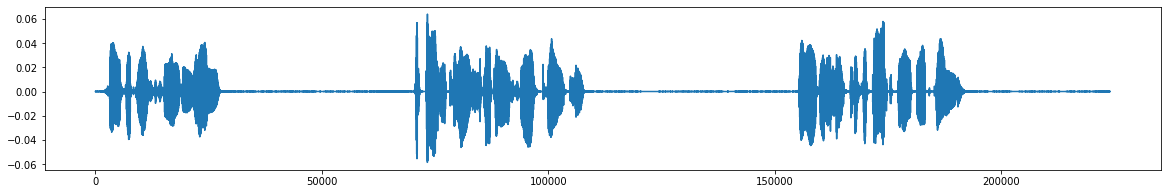

In [16]:
#visualization
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

In [17]:
#check
STT(data)

'HARVARD LIST NUMBER ONE THE BIRCH CANOE SLID ON THE SMOOTH PLANKS GLEW THE SHEET TO THE DARK BLUE BACKGROUND'

##2) Add Noise in Different Way


### a) making noise into freq level

In [18]:
noise_len = 2 # seconds
#give white noise block
#if u want to know about band_limited_noise, see below annotation block.
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)
noise1 = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10

audio_band_limited = data+noise

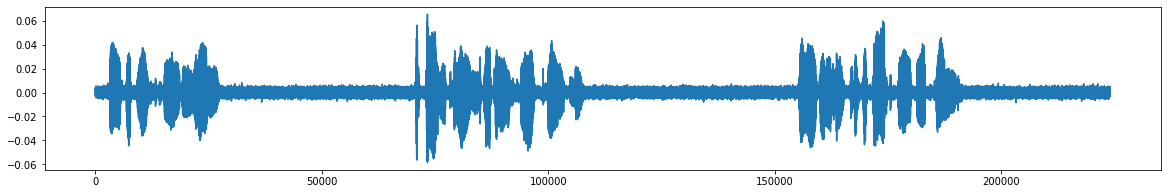

In [19]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_band_limited)
IPython.display.Audio(data=audio_band_limited, rate=rate)

In [20]:
STT(audio_band_limited)

'HALF AD LIST NUMBER ONE THE BIRCH CANOE SLID ON THE SMOOVE PLANKS DHREW THE SHEET TO THE DARK BLUE BACKGROUND'

In [21]:
# def fftnoise(f):
#     f = np.array(f, dtype='complex')
#     Np = (len(f) - 1) // 2
#     phases = np.random.rand(Np) * 2 * np.pi
#     phases = np.cos(phases) + 1j * np.sin(phases)
#     f[1:Np+1] *= phases
#     f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
#     return np.fft.ifft(f).real

# def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
#     freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
#     f = np.zeros(samples)
#     idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
#     f[idx] = 1
#     return fftnoise(f)

### b) assuming specific environment
cafe noise & aircondition noise

In [40]:
# cafe noise
noise_data, noise_rate = librosa.load('assets_cafe_short.wav', sr=16000)

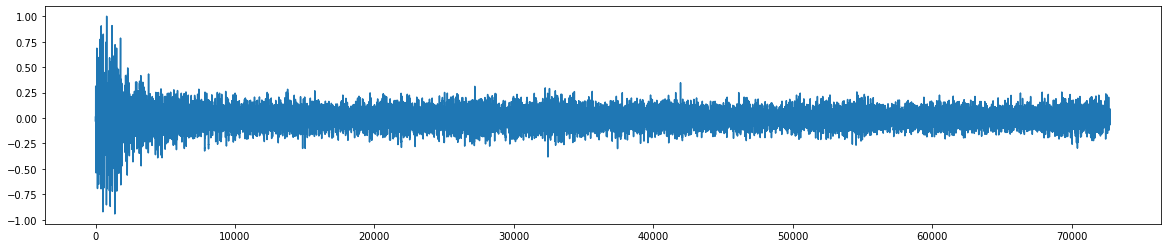

In [23]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [24]:
snr = 16 # signal to noise ratio
noise_clip = noise_data / snr #control the noise level
noise_clip = np.tile(noise_clip, 10) #repeat the environment sound
noise_clip = noise_clip[:len(data)] #tream it for synthesizing raw data
audio_clip_cafe = data + noise_clip

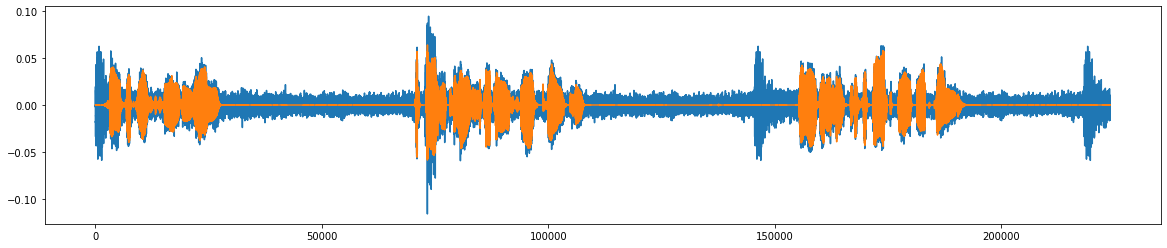

In [25]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(audio_clip_cafe)
ax.plot(data)
IPython.display.Audio(data=audio_clip_cafe, rate=16000)

In [26]:
STT(audio_clip_cafe)

'E OFFED LIST N ON T LONG THE BURS CANNE LID O MUSMAS ANKS BETHREW THE SHEET TO THE DOG LAVE BACK GROUND BE'

In [44]:
#air condition
noise_data2, noise_rate2 = librosa.load('AirConditioner_1.wav', sr=16000)

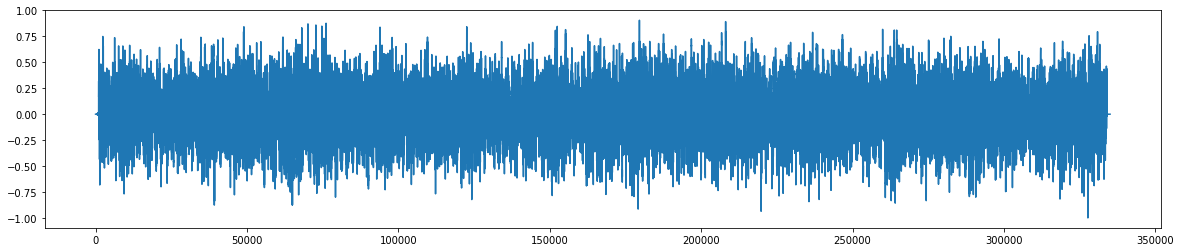

In [45]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data2)
IPython.display.Audio(data=noise_data2, rate=noise_rate2)

In [48]:
snr = 16 # signal to noise ratio
noise_clip = noise_data2 / snr #control the noise level
noise_clip = np.tile(noise_clip, 10) #repeat the environment sound
noise_clip = noise_clip[:len(data)] #tream it for synthesizing raw data
audio_clip_air = data + noise_clip

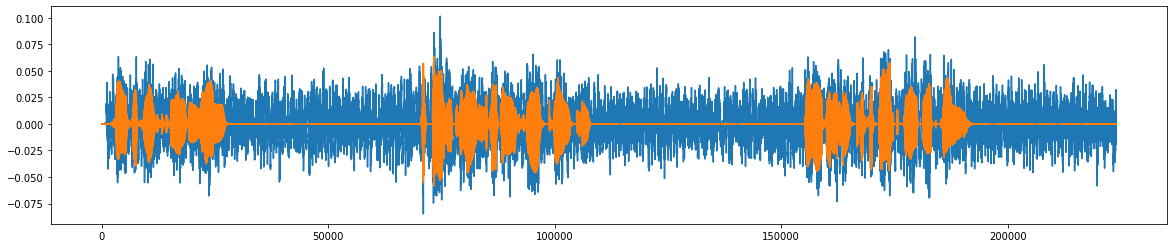

In [49]:
fig, ax = plt.subplots(figsize=(20,4))

ax.plot(audio_clip_air)
ax.plot(data)
IPython.display.Audio(data=audio_clip_air, rate=16000)

In [51]:
STT(audio_clip_air)

'OFFAT LIST ON THE ONE THE BIRCH CANOE SLID ON THE SMOETH PLANKS DREW THE SHEET OF THE DOK MROOT BAT ROUND'

## 3) Remove Noise on 2 Way

### a) Stationary Way

In [27]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, y_noise = noise_clip, n_std_thresh_stationary=2,stationary=True)

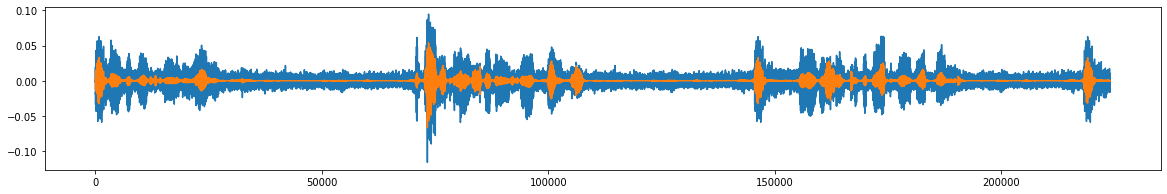

In [28]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)

IPython.display.Audio(data=reduced_noise, rate=rate)

In [29]:
STT(reduced_noise)

'AFF AD LIFT NUMBER ONE THE BIRCH KANEES SLID ON THE SMEETH HANKS THREW THE SHEET OF THE DARK BLUE BACKGROUND'

### b) non-stationary

In [30]:
reduced_noise_non = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

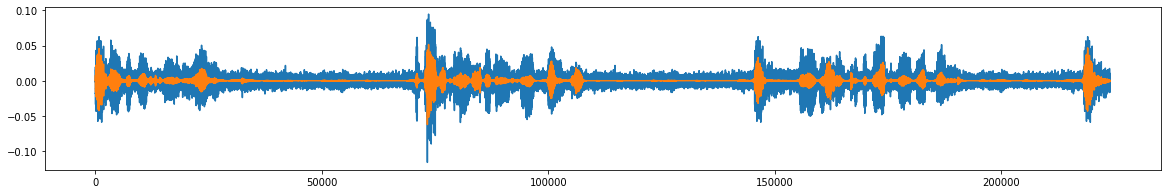

In [31]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise_non, alpha = 1)
IPython.display.Audio(data=reduced_noise_non, rate=rate)

##4) Wrap Up

In [36]:
print(STT(data))
IPython.display.Audio(data=data, rate=rate)

HARVARD LIST NUMBER ONE THE BIRCH CANOE SLID ON THE SMOOTH PLANKS GLEW THE SHEET TO THE DARK BLUE BACKGROUND


In [37]:
print(STT(audio_clip_cafe))
IPython.display.Audio(data=audio_clip_cafe, rate=rate)

E OFFED LIST N ON T LONG THE BURS CANNE LID O MUSMAS ANKS BETHREW THE SHEET TO THE DOG LAVE BACK GROUND BE


In [52]:
print(STT(audio_clip_air))
IPython.display.Audio(data=audio_clip_air, rate=rate)

OFFAT LIST ON THE ONE THE BIRCH CANOE SLID ON THE SMOETH PLANKS DREW THE SHEET OF THE DOK MROOT BAT ROUND


In [38]:
print(STT(reduced_noise_non))
IPython.display.Audio(data=reduced_noise_non, rate=rate)

O OFFERT LIFT NUBER ONE THE BIRCH KINOES SLID ON E SMOETH PANKS  THREW THE SHEET OF THE DARK BLUE BACKGROUND B


In [39]:
print(STT(reduced_noise))
IPython.display.Audio(data=reduced_noise, rate=rate)

AFF AD LIFT NUMBER ONE THE BIRCH KANEES SLID ON THE SMEETH HANKS THREW THE SHEET OF THE DARK BLUE BACKGROUND


##Future Work
- fine-tuning specific noisy environment.
- and getting more precise result than previous example.